# **Spam Filtering Using The Multinomial Naive Bayes Algorithm**

In [2]:
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## 1- Data Handeling 

- Reading the dataset and nameing the columns

In [15]:
df = pd.read_csv('emails', sep='\t',header=None, names=['Label', 'SMS'])
print(df.shape)
df.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- Cleaning the data

In [16]:
df.describe()

,Label,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [17]:
df.duplicated().sum()

403

In [18]:
dataset = df.copy()
dataset= dataset.drop_duplicates()
dataset.dropna(subset=['Label'],inplace=True)

In [19]:
dataset.shape

(5169, 2)

- Getting the probability of Ham and Spam sms

In [20]:
dataset['Label'].value_counts(normalize=True)

ham     0.87367
spam    0.12633
Name: Label, dtype: float64

- Splitting the dataset into train and test sets with the same ratio

In [21]:
# Calculate index for split
training_test_index = round(len(dataset) * 0.8)

In [22]:
# Split into training and test sets
training_set = dataset[:training_test_index].reset_index(drop=True)
test_set = dataset[training_test_index:].reset_index(drop=True)

In [23]:
print(training_set.shape)
print(test_set.shape)

(4135, 2)
(1034, 2)


In [24]:
training_set['Label'].value_counts(normalize=True)

ham     0.870375
spam    0.129625
Name: Label, dtype: float64

In [25]:
test_set['Label'].value_counts(normalize=True)

ham     0.886847
spam    0.113153
Name: Label, dtype: float64

In [26]:
# Before cleaning
training_set.head(3)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


- Removing all special chars 
- Converting to lowercase

In [27]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace(
   '\W', ' ') # Removes punctuation
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head(3)

,Label,SMS
0,ham,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...


- Creating the Vocabulary


In [28]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
   for word in sms:
      vocabulary.append(word)

vocabulary = list(set(vocabulary))

In [29]:
len(vocabulary)


7792

In [30]:
vocabulary[41:50]

['springs',
 'katexxx',
 'gm',
 'guitar',
 '20p',
 'doors',
 'head',
 'refused',
 'also']

- creating the dictionary and concatenating it with the dataset

In [31]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
   for word in sms:
      word_counts_per_sms[word][index] += 1

In [32]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,ukp,mornin,dane,xxx,studentfinancial,help08714742804,show,trivia,login,invest,forth,09058094599,ad,courageous,completes,m221bp,guilty,basic,arguing,chasing,answers,apologize,ended,houseful,8am,regard,cons,repent,anyhow,3230,vibrate,nightnight,vegas,22,gotten,nav,captaining,blood,81303,wnevr,...,lucyxx,concentrate,ghodbandar,resizing,eight,yeesh,goodmate,pickle,forgiven,lunsford,released,clos1,lets,wicklow,upd8,spose,bellearlier,gifts,seriously,wishing,aboutas,pros,swimming,hardest,rugby,players,costs,owned,feeling,previews,safety,gent,knock,hella,math,rounds,replacing,09090204448,teaching,block
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,ukp,mornin,dane,xxx,studentfinancial,help08714742804,show,trivia,login,invest,forth,09058094599,ad,courageous,completes,m221bp,guilty,basic,arguing,chasing,answers,apologize,ended,houseful,8am,regard,cons,repent,anyhow,3230,vibrate,nightnight,vegas,22,gotten,nav,captaining,blood,...,lucyxx,concentrate,ghodbandar,resizing,eight,yeesh,goodmate,pickle,forgiven,lunsford,released,clos1,lets,wicklow,upd8,spose,bellearlier,gifts,seriously,wishing,aboutas,pros,swimming,hardest,rugby,players,costs,owned,feeling,previews,safety,gent,knock,hella,math,rounds,replacing,09090204448,teaching,block
0,ham,"[go, until, jurong, point, crazy, available, o...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ham,"[ok, lar, joking, wif, u, oni]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ham,"[u, dun, say, so, early, hor, u, c, already, t...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ham,"[nah, i, don, t, think, he, goes, to, usf, he,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2- Building the algorithm

In [34]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

- Calculating the constants

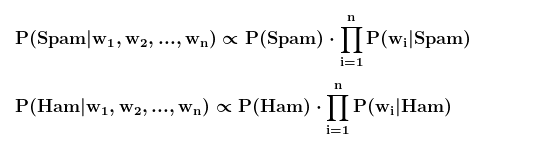

In [3]:
Image('1.png')

In [37]:
# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

In [38]:
# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

In [39]:
# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

Text(0.5, 0, 'Message Length')

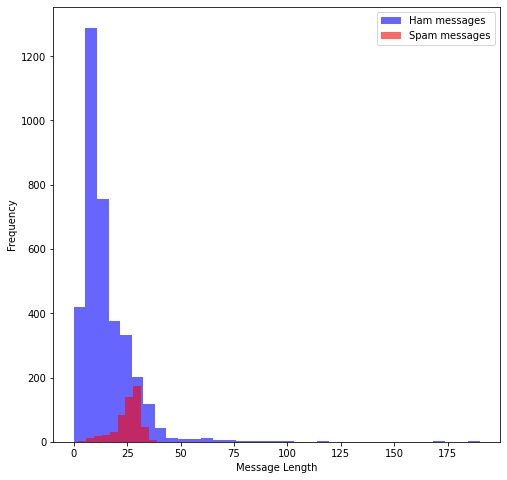

In [40]:
plt.figure(figsize=(8, 8))

n_words_per_ham_message.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
n_words_per_spam_message.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

In [41]:
# N_Vocabulary
n_vocabulary = len(vocabulary)

In [42]:
# Laplace smoothing
alpha = 1

- Calculating the parameters

In [43]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

In [44]:
Image('2.png')

In [45]:

# Calculate parameters
for word in vocabulary:
   n_word_given_spam = spam_messages[word].sum() # spam_messages already defined
   p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
   parameters_spam[word] = p_word_given_spam

   n_word_given_ham = ham_messages[word].sum() # ham_messages already defined
   p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
   parameters_ham[word] = p_word_given_ham

- Classifying the message

In [46]:
import re

def classify(message):
   '''
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham: 
         p_ham_given_message *= parameters_ham[word]

   print('P(Spam|message):', p_spam_given_message)
   print('P(Ham|message):', p_ham_given_message)

   if p_ham_given_message > p_spam_given_message:
      print('Ham')
   elif p_ham_given_message < p_spam_given_message:
      print('Spam')
   else:
      print('Equal proabilities, have a human classify this!')

In [47]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')


P(Spam|message): 8.327525375969207e-26
P(Ham|message): 2.9313100883275154e-27
Spam


In [48]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 7.291465608065036e-25
P(Ham|message): 4.5752011463649364e-21
Ham


## 3- Measuring the Accuracy

In [49]:
def classify_test_set(message):
   '''
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham:
         p_ham_given_message *= parameters_ham[word]

   if p_ham_given_message > p_spam_given_message:
      return 'ham'
   elif p_spam_given_message > p_ham_given_message:
      return 'spam'
   else:
      return 'needs human classification'

In [50]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,"When you get free, call me",ham
1,ham,How have your little darlings been so far this...,ham
2,ham,Still at west coast... Haiz... Ü'll take forev...,ham
3,ham,MMM ... Fuck .... Merry Christmas to me,ham
4,ham,alright. Thanks for the advice. Enjoy your nig...,ham


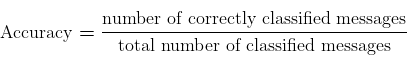

In [4]:
Image('3.png')

In [52]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
   row = row[1]
   if row['Label'] == row['predicted']:
      correct += 1

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1019
Incorrect: 15
Accuracy: 0.9854932301740812
